In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from catboost import Pool


import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 

## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [2]:
!pwd

/home/aiffel-dj45/aiffel/kaggle_kakr_housing


In [3]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print('train data dim : {}'.format(train.shape))
print('sub data dim : {}'.format(test.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [4]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [6]:
train.price.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

# id, date 변수 정리.

In [7]:
sub_id = train['id'][len(train):]
del train['id']
train['date'] = train['date'].apply(lambda x : str(x[:6])).astype(str)

# 각 변수들의 분포 확인


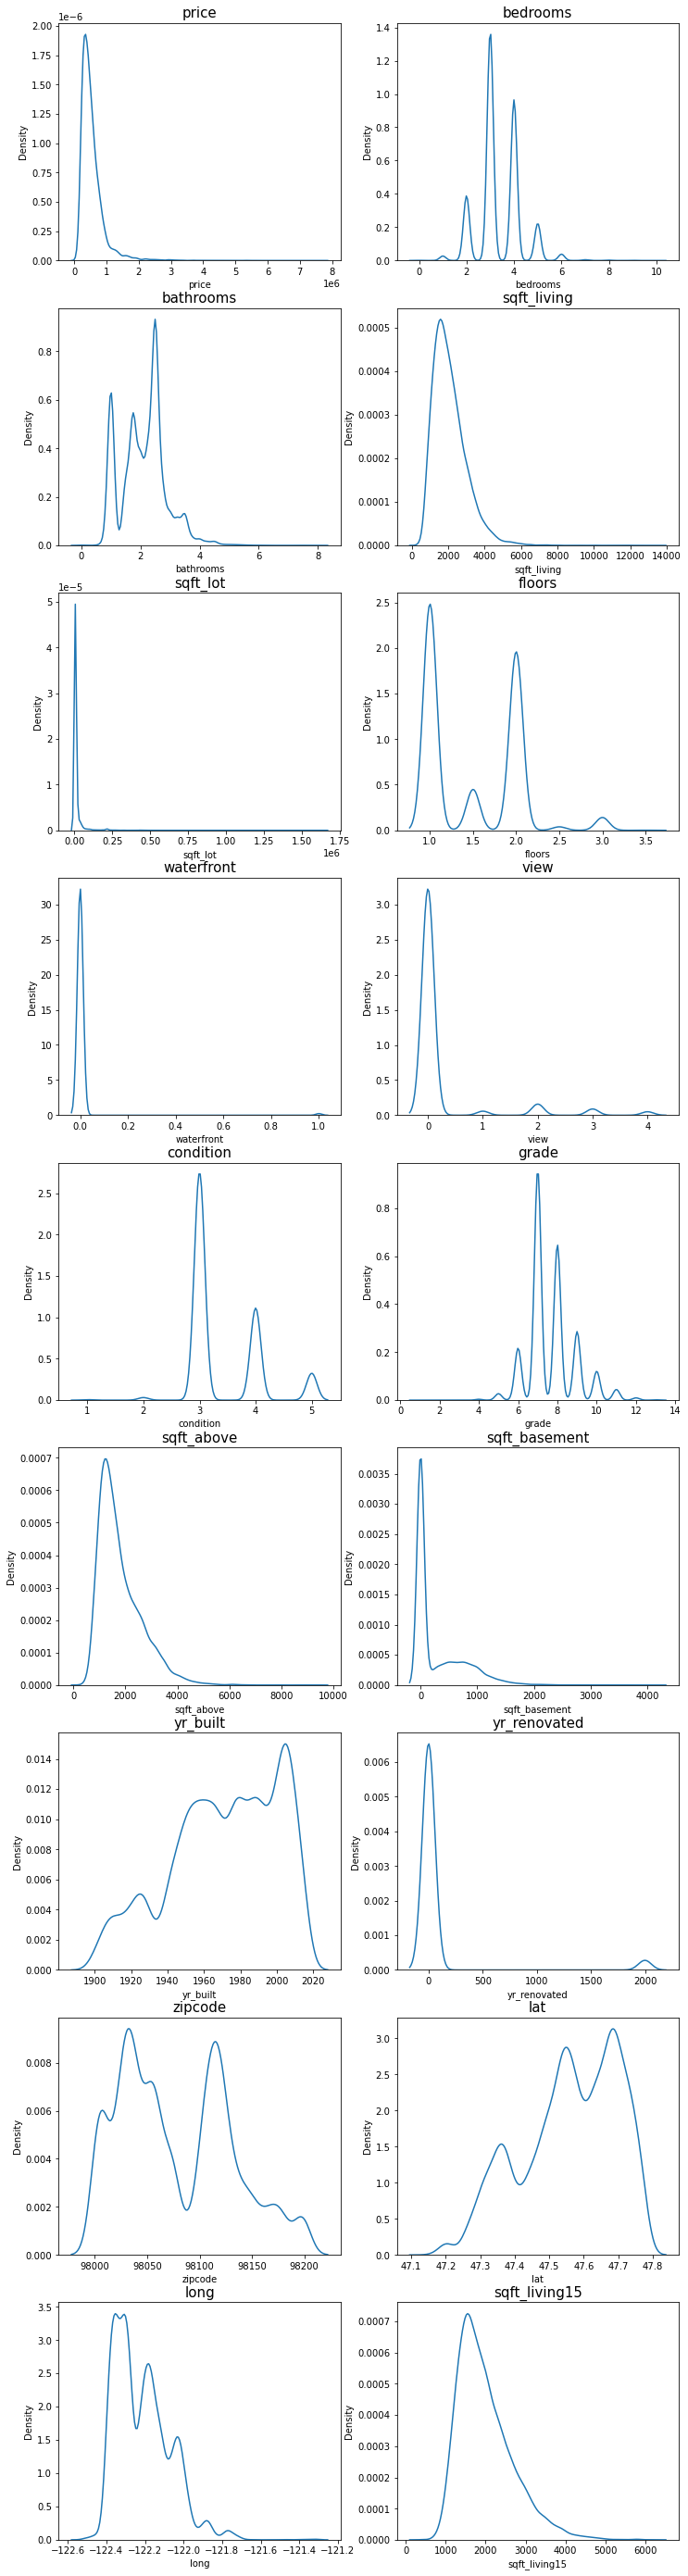

In [8]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = train.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(train[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

위 그래프를 보아 값이 한쪽으로 치우친 feature들을 log scaling시켜 normaliszing

In [9]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

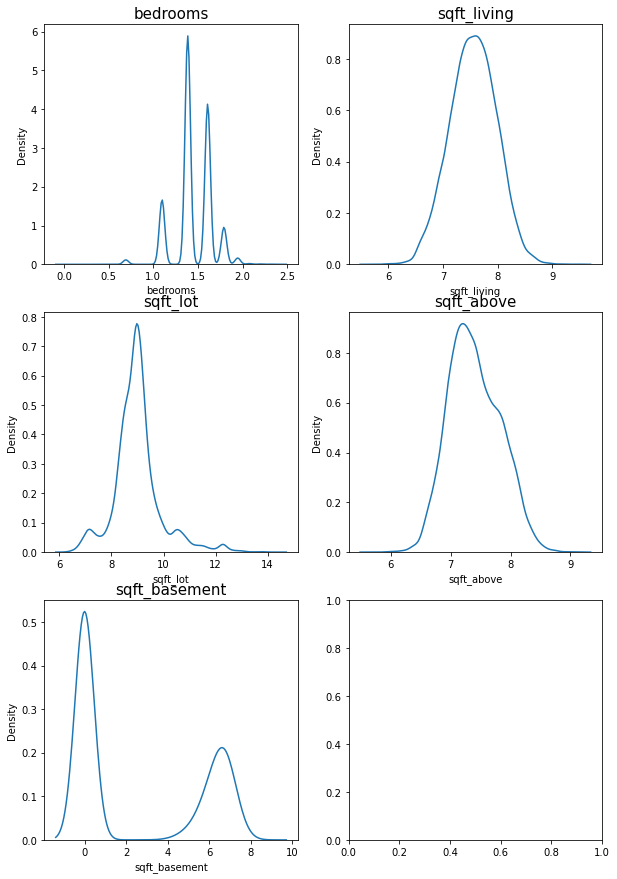

In [10]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(train[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1


<AxesSubplot:>

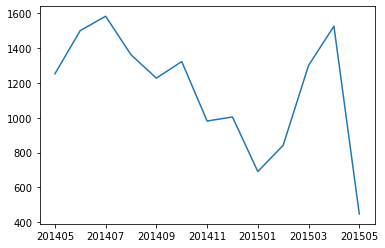

In [11]:
train['date'].value_counts().sort_index().plot()

- 기간이 짧아 timeseries로 moving average를 사용하진 못할듯

date feature를 int로 바꾸면서 뒤에 쓸다리없는 값 빼보리기

In [12]:
train['date'] = train['date'].apply(lambda x : str(x[:8])).astype(int)
test['date'] = test['date'].apply(lambda x : str(x[:8])).astype(int)

train['date'] = train['date'].astype('int')
test['date'] = test['date'].astype('int')

- predict할 y값 log-scaling 해주고 로 빼주면서 x_trint, y_train 분리

- test set에서 id column drop해줌

In [13]:
X = train.drop(["price"], axis=1)
y = np.log1p(train["price"].values)

X_test = test.drop(["id"], axis=1)

# train, test data split

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [15]:
len(X_train)

12028

In [16]:
len(X_valid)

3007

# LightGBM Modeling

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (roc_curve, auc, accuracy_score)

- GridSearch

In [18]:
lgbm_gridParams = {
    'learning_rate': [0.005, 0.01],
    'n_estimators': [8,16,24],
    'num_leaves': [6,8,12,16], # large num_leaves helps improve accuracy but might lead to over-fitting
    'boosting_type' : ['dart'], 
    'max_bin':[255, 510], # large max_bin helps improve accuracy but might slow down training progress
    'random_state' : [500],
    'subsample' : [0.7,0.75],
    'reg_alpha' : [1,1.2],
    'reg_lambda' : [1,1.2,1.4],
    }


In [19]:
model = lgb.LGBMRegressor(random_state=2019)

lgmb_grid = GridSearchCV(model, lgbm_gridParams, verbose=1, cv=4, n_jobs=-1)

lgmb_grid.fit(X, y)

print(lgmb_grid.best_params_)
print(lgmb_grid.best_score_)

Fitting 4 folds for each of 576 candidates, totalling 2304 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 780 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 1480 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 2304 out of 2304 | elapsed:   18.5s finished


{'boosting_type': 'dart', 'learning_rate': 0.01, 'max_bin': 255, 'n_estimators': 8, 'num_leaves': 16, 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1.2, 'subsample': 0.7}
0.09274923742588001


In [20]:
lgb_preds = np.expm1(lgmb_grid.best_estimator_.predict(X_test))

In [21]:
lgb_preds

array([464242.32695413, 454543.44960795, 492697.90767432, ...,
       463856.48775843, 463856.48775843, 469913.39192114])

In [22]:
submission = pd.read_csv('./data/submission.csv')

submission['price'] = lgb_preds

submission_csv_path = './data/lgbm_sub.csv'
submission.to_csv(submission_csv_path, index=False)

In [23]:
lgmb_grid.best_params_

{'boosting_type': 'dart',
 'learning_rate': 0.01,
 'max_bin': 255,
 'n_estimators': 8,
 'num_leaves': 16,
 'random_state': 500,
 'reg_alpha': 1,
 'reg_lambda': 1.2,
 'subsample': 0.7}

In [24]:
# X_train, X_valid, y_train, y_valid

params = {
    "objective" : "regression",
    "metric" : "rmse",
    "num_leaves" : 16,
    "learning_rate" : 0.01,
    "bagging_fraction" : 0.6,
    "feature_fraction" : 0.6,
    "bagging_frequency" : 6,
    "bagging_seed" : 42,
    "verbosity" : -1,
    "seed": 42
}

lgtrain = lgb.Dataset(X_train, label=y_train)
lgval = lgb.Dataset(X_valid, label=y_valid)
evals_result = {}
model = lgb.train(params, lgtrain, 5000, 
                  valid_sets=[lgtrain, lgval], 
                  early_stopping_rounds=100, 
                  verbose_eval=150, 
                  evals_result=evals_result)

lgbm_pred = np.expm1(model.predict(X_test, num_iteration=model.best_iteration))

[LightGBM] [Warning] Unknown parameter: bagging_frequency
Training until validation scores don't improve for 100 rounds
[150]	training's rmse: 0.255707	valid_1's rmse: 0.260066
[300]	training's rmse: 0.190447	valid_1's rmse: 0.199452
[450]	training's rmse: 0.17022	valid_1's rmse: 0.182429
[600]	training's rmse: 0.161287	valid_1's rmse: 0.175727
[750]	training's rmse: 0.155845	valid_1's rmse: 0.172169
[900]	training's rmse: 0.151957	valid_1's rmse: 0.170061
[1050]	training's rmse: 0.148907	valid_1's rmse: 0.168607
[1200]	training's rmse: 0.146263	valid_1's rmse: 0.167535
[1350]	training's rmse: 0.143944	valid_1's rmse: 0.166721
[1500]	training's rmse: 0.141779	valid_1's rmse: 0.166032
[1650]	training's rmse: 0.139769	valid_1's rmse: 0.165492
[1800]	training's rmse: 0.137907	valid_1's rmse: 0.165023
[1950]	training's rmse: 0.13616	valid_1's rmse: 0.16457
[2100]	training's rmse: 0.134526	valid_1's rmse: 0.164262
[2250]	training's rmse: 0.132957	valid_1's rmse: 0.163954
[2400]	training's r

In [25]:

submission = pd.read_csv('./data/submission.csv')

submission['price'] = pred_test_y

submission_csv_path = './data/lgbm_sub.csv'
submission.to_csv(submission_csv_path, index=False)


"\nsubmission = pd.read_csv('./data/submission.csv')\n\nsubmission['price'] = pred_test_y\n\nsubmission_csv_path = './data/lgbm_sub.csv'\nsubmission.to_csv(submission_csv_path, index=False)\n"

In [34]:
!pwd

/home/aiffel-dj45/aiffel/kaggle_kakr_housing


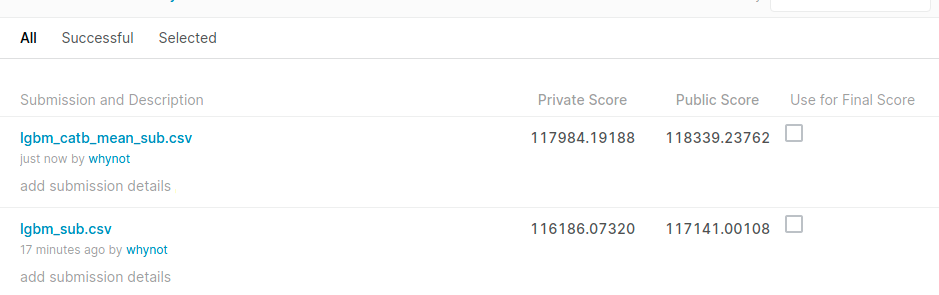

In [38]:
from IPython.display import Image
Image("./data/score.png")

# 목표 score 달성 실패~

- 아래 blending model은 성능향상이 없어 pass

In [ ]:
break

In [26]:
cb_model = CatBoostRegressor(iterations=500,
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)

In [27]:
# X_train, X_valid, y_train, y_valid

cb_model.fit(X_train, y_train,
             eval_set=(X_valid, y_valid),
             use_best_model=True,
             verbose=50)

0:	learn: 0.5090945	test: 0.5091021	best: 0.5091021 (0)	total: 70.6ms	remaining: 35.2s
50:	learn: 0.1925791	test: 0.2010175	best: 0.2010175 (50)	total: 636ms	remaining: 5.6s
100:	learn: 0.1616243	test: 0.1765582	best: 0.1765582 (100)	total: 1.17s	remaining: 4.63s
150:	learn: 0.1499936	test: 0.1698412	best: 0.1698412 (150)	total: 1.7s	remaining: 3.93s
200:	learn: 0.1413076	test: 0.1661412	best: 0.1661412 (200)	total: 2.23s	remaining: 3.32s
250:	learn: 0.1339061	test: 0.1641664	best: 0.1641664 (250)	total: 2.76s	remaining: 2.74s
300:	learn: 0.1277076	test: 0.1628704	best: 0.1628704 (300)	total: 3.29s	remaining: 2.18s
350:	learn: 0.1224673	test: 0.1620021	best: 0.1620021 (350)	total: 3.83s	remaining: 1.62s
400:	learn: 0.1178602	test: 0.1615239	best: 0.1615239 (400)	total: 4.36s	remaining: 1.07s
450:	learn: 0.1131611	test: 0.1611247	best: 0.1611078 (446)	total: 4.89s	remaining: 531ms
499:	learn: 0.1088424	test: 0.1608957	best: 0.1608635 (495)	total: 5.41s	remaining: 0us

bestTest = 0.16086

In [28]:
cat_pred = np.expm1(cb_model.predict(X_test))

In [32]:
pred = pd.DataFrame(cat_pred, columns=['cat_pred'])
pred['lgbm_pred'] = lgbm_pred
pred.head(20)

,cat_pred,lgbm_pred
0,5.658236e+05,5.320894e+05
1,5.151634e+05,5.147766e+05
2,1.410295e+06,1.560738e+06
3,3.088498e+05,2.736680e+05
4,3.268999e+05,3.332122e+05
5,3.266048e+05,3.280714e+05
6,4.753813e+05,4.441549e+05
7,6.829792e+05,6.980564e+05
8,2.996526e+05,3.218570e+05
9,4.546868e+05,4.732028e+05


In [31]:
np.mean(pred, axis=1)

0       5.489565e+05
1       5.149700e+05
2       1.485516e+06
3       2.912589e+05
4       3.300561e+05
            ...     
6463    2.751456e+05
6464    4.599167e+05
6465    5.000333e+05
6466    3.672211e+05
6467    4.572393e+05
Length: 6468, dtype: float64

In [33]:

submission = pd.read_csv('./data/submission.csv')

submission['price'] = np.mean(pred, axis=1)

submission_csv_path = './data/lgbm_catb_mean_sub.csv'
submission.to_csv(submission_csv_path, index=False)
